In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import numpy as np
import tensorflow as tf
from joblib import load,dump
from rdkit import Chem
import pandas as pd

from deepchem.models import GraphConvModel, MPNNModel
import deepchem as dc
from deepchem.molnet.preset_hyper_parameters import hps
from copy import deepcopy
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
%matplotlib inline
#os.environ.setdefault('DEEPCHEM_DATA_DIR', os.popen('pwd').read().strip())

/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env

In [2]:
dc.__version__

'2.1.1'

In [3]:
seed = 777
np.random.seed(seed)
tf.set_random_seed(seed)

In [4]:
def featurize_data(tasks, smiles_col, featurizer, dataset_file, normalize = True):
    loader = dc.data.CSVLoader(tasks=tasks, smiles_field=smiles_col, featurizer=featurizer)
    dataset = loader.featurize(dataset_file, shard_size=8192)
    move_mean = True
    if normalize:
        transformers = [dc.trans.NormalizationTransformer(
            transform_y=True, dataset=dataset, move_mean=move_mean)]
    else:
        transformers = []
    for transformer in transformers:
        dataset = transformer.transform(dataset)
    return dataset, transformers

In [5]:
featurizer = dc.feat.graph_features.WeaveFeaturizer()
metric = dc.metrics.Metric(dc.metrics.rms_score, np.mean)

# use the same dataset as MolMapNet and attentivFP

In [6]:
tasks = ['measured log solubility in mols per litre']
smiles_col = 'smiles'

# tasks, delaney_datasets, transformers = dc.molnet.load_delaney(featurizer='Weave', split='random')
# train_dataset, valid_dataset, test_dataset = delaney_datasets
train_dataset, transformers =  featurize_data(tasks = tasks, smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../train.csv')

valid_dataset, _ =  featurize_data(tasks = tasks, smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../valid.csv')

test_dataset, _ =  featurize_data(tasks = tasks, smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../test.csv')

etc_dataset, _ =  featurize_data(tasks = ['Exp_LogS'], smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../etc.csv')


Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../train.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.168 s
TIMING: dataset construction took 1.369 s
Loading dataset from disk.
TIMING: dataset construction took 0.269 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../valid.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.155 s
TIMING: dataset construction took 0.180 s
Loading dataset from disk.
TIMING: dataset construction took 0.031 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../test.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.130 s
TIMING: dataset construction took 0.150 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to

In [7]:
# Fit trained model use best parameters
n_atom_feat = 75
n_pair_feat = 14

# Batch size of models
batch_size = 64
patience = 30

lr = 1e-5

model = dc.models.MPNNModel(
                            len(tasks),
                            n_atom_feat=n_atom_feat,
                            n_pair_feat=n_pair_feat,
                            T=3,
                            M=5,
                            batch_size=batch_size,
                            learning_rate=lr,
                            use_queue=False,
                            mode="regression")



def count_params(model):
    trainable_paras = 0
    for layer in model.layers.values():
        x = model.get_layer_variable_values(layer)
        for  i in x:
            if type(i) == np.ndarray:
                if len(i.shape) == 1:
                    trainable_paras += i.shape[0]
                else:
                    a, b = i.shape
                    trainable_paras += a*b
    return trainable_paras

In [8]:
#count_params(model)

In [9]:
## perform an early stopping strategy
best_rmse = np.inf
patience = 30
epochs = 500
model_performace = {}
wait = 0

for i in range(epochs):
    
    train_dataset.shuffle_each_shard()
    
    model.fit(train_dataset, nb_epoch=1, verbos = 0)
    valid_scores = model.evaluate(valid_dataset, [metric], transformers)
    valid_rmse = valid_scores.get('mean-rms_score')
    model_performace[i] = valid_rmse
    
    
    if  valid_rmse < best_rmse:
        best_rmse = valid_rmse
        print(best_rmse)
        wait = 0        
        best_train_rmse = model.evaluate(train_dataset, [metric], transformers).get('mean-rms_score')
        best_valid_rmse = model.evaluate(valid_dataset, [metric], transformers).get('mean-rms_score')        
        best_test_rmse = model.evaluate(test_dataset, [metric], transformers).get('mean-rms_score')
        best_etc_rmse = model.evaluate(etc_dataset, [metric], transformers).get('mean-rms_score')

        best_train_pred_y = list(model.predict(train_dataset, transformers).reshape(-1,))
        best_valid_pred_y = list(model.predict(valid_dataset, transformers).reshape(-1,))           
        best_test_pred_y = list(model.predict(test_dataset, transformers).reshape(-1,))                 
        best_etc_pred_y = list(model.predict(etc_dataset, transformers).reshape(-1,))             
        
        
        best_epoch = i
    else:
        wait += 1
        if wait >= patience:
            print('early stopping at best_rmse : %s...' % best_rmse)
            break

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [2.052050322784845]
2.052050322784845
computed_metrics: [2.030105729927619]
computed_metrics: [2.0520503214064085]
computed_metrics: [2.0384362016107063]
computed_metrics: [2.177830568515518]
computed_metrics: [2.0113017392691215]
2.0113017392691215
computed_metrics: [1.9657113316710049]
computed_metrics: [2.011301740019117]
computed_metrics: [1.9799491285323032]
computed_metrics: [2.3822621481669617]
computed_metrics: [1.980050856246327]
1.980050856246327
computed_metrics: [1.9099340349027525]
computed_metrics: [1.9800508458162656]
computed_metrics: [1.9300919226924316]
computed_metrics: [2.6666016293521437]
computed_metrics: [1.9404120514956298]
1.9404120514956298
computed_metrics: [1.855252488097508]
computed_metrics: [1.9404120429197236]
computed_metrics: [1.8906670086778208]
computed_metrics: [2.8349470884345975]
computed_metrics: [1.9046259126768819]
1.9046259126768819
computed_metrics: [1.7978632605349978]
computed_metrics: [1.904625901764878]
computed_metrics:

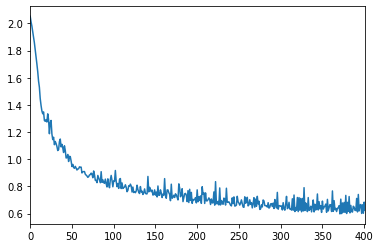

In [10]:
pd.Series(model_performace).plot()

In [11]:
final_res = {'train_rmse':best_train_rmse, 
             'valid_rmse':best_valid_rmse, 
             'test_rmse':best_test_rmse,              
             'etc_rmse':best_etc_rmse,

#              'train_pred_y':best_train_pred_y,
#              'test_pred_y':best_test_pred_y,
             'etc_pred_y':best_etc_pred_y, 


             '# trainable params': count_params(model),
             'random_seed':seed, 
             'best_epoch': best_epoch,

             'batch_size':batch_size,
             #'lr': lr,

            }

final_res

{'train_rmse': 0.4075678623775436,
 'valid_rmse': 0.5979305099794955,
 'test_rmse': 0.9164608024586882,
 'etc_rmse': 2.0082936798504902,
 'etc_pred_y': [-3.8002589453092637,
  -3.5250247155452814,
  -3.4418943016309034,
  -3.5460848940607947,
  -4.1600954587152845,
  -3.2815245747352693,
  -4.298845807948406,
  -4.623653852699347,
  -4.117678570341932,
  -3.692259218935889,
  -3.298390435406101,
  -3.7453514254332902,
  -3.5007460616337474,
  -3.699454611744531,
  -3.435146552840318,
  -3.496105286022912,
  -3.628803093347281,
  -3.3144020523566584,
  -3.552327647507995,
  -3.718782799215128,
  -3.639531175955968,
  -3.4457898579796815,
  -3.6775698774396988,
  -3.534017896837717,
  -3.459094574621492,
  -3.5723328842979654,
  -3.444918516415315,
  -3.520072920502213,
  -3.50673441940621,
  -3.8074357376880688,
  -3.749657045339843,
  -3.0669145620370832,
  -3.035842236558175,
  -3.151539021669903,
  -3.9394760767578068,
  -3.085213834148886,
  -3.6983793930197955,
  -3.815022182390655